# CNN and SVM

GPU Configurations:-

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

In [3]:
tf.__version__

'2.9.1'

# Explore the dataset

In [4]:
data_dir = pathlib.Path('../dataset_stages/train')
data_dir

WindowsPath('../dataset_stages/train')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

11521


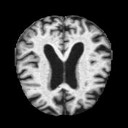

In [6]:
mild = list(data_dir.glob('Mild_Demented/*'))
PIL.Image.open(str(mild[0]))

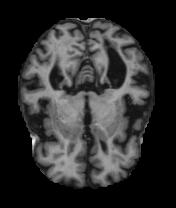

In [7]:
PIL.Image.open(str(mild[1]))

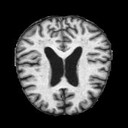

In [8]:
v_mild = list(data_dir.glob('Very_Mild_Demented/*'))
PIL.Image.open(str(v_mild[0]))

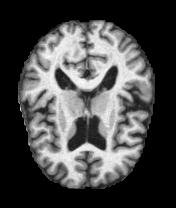

In [9]:
PIL.Image.open(str(v_mild[42]))

# Load using keras.preprocessing

### Create a dataset

In [10]:
batch_size = 16
img_height = 180
img_width = 180

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  labels='inferred',
  label_mode='int',
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds

Found 11521 files belonging to 4 classes.
Using 10369 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  labels='inferred',
  label_mode='int',
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds

Found 11521 files belonging to 4 classes.
Using 1152 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
class_names = train_ds.class_names
print(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


# Visualize the data

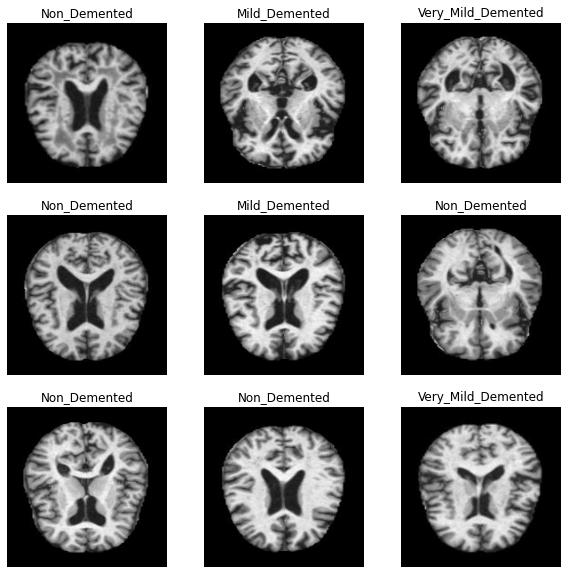

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    
plt.savefig('stages.png')

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 180, 180, 3)
(16,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image)) 

# Create the model

In [19]:
base_model = tf.keras.models.load_model('../saved_model/base_model.h5')

In [20]:
base_model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 23, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 64)          1

In [21]:
base_model.trainable = False

In [22]:
feature1 = Sequential([
    tf.keras.layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', strides=2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', strides=2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', strides=2, activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalMaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='linear', name="SVM")
], name='feature1')

In [23]:
num_classes = 4

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
# preprocess = tf.keras.layers.Rescaling(1./255)(inputs)
# conv1 = layers.Conv2D(16, 3, padding='same', strides=2, activation='relu')(preprocess)
# maxpool1 = layers.MaxPooling2D()(conv1)
# conv2 = layers.Conv2D(32, 3, padding='same', strides=2, activation='relu')(maxpool1)
# maxpool2 = layers.MaxPooling2D()(conv2)
# conv3 = layers.Conv2D(64, 3, padding='same', strides=2, activation='relu')(maxpool2)
# maxpool3 = layers.MaxPooling2D()(conv3)
# global_maxpool = layers.GlobalMaxPooling2D()(maxpool3)
# flatten = layers.Flatten()(global_maxpool)
# dense1 = layers.Dense(128, activation='relu')(flatten)
# dense2 = layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='linear', name="SVM")(dense1)
feature1 = feature1(inputs)
feature2 = base_model(inputs)

concat = layers.Concatenate()([feature1, feature2])

output = layers.Dense(num_classes, activation='softmax')(concat)

In [24]:
model = tf.keras.models.Model(inputs = [inputs], outputs = output)

# Compile the model

In [25]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Model summary

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 feature1 (Sequential)          (None, 128)          48416       ['input_1[0][0]']                
                                                                                                  
 base_model (Sequential)        (None, 2)            48674       ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 130)          0           ['feature1[0][0]',           

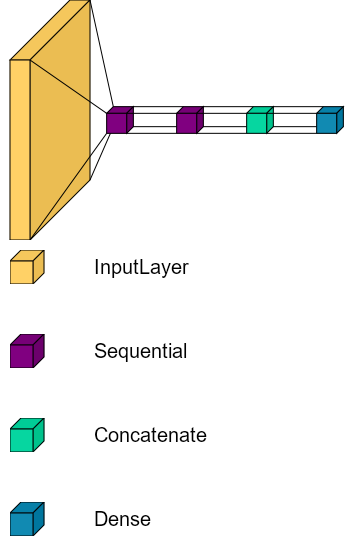

In [27]:
import visualkeras
from PIL import ImageFont
from collections import defaultdict

color_map = defaultdict(dict)
color_map[Sequential]['fill'] = 'purple'

font = ImageFont.truetype("arial.ttf", 20)
visualkeras.layered_view(model, legend=True, font=font, color_map=color_map, spacing=50, scale_xy=1, to_file='final_model.png')

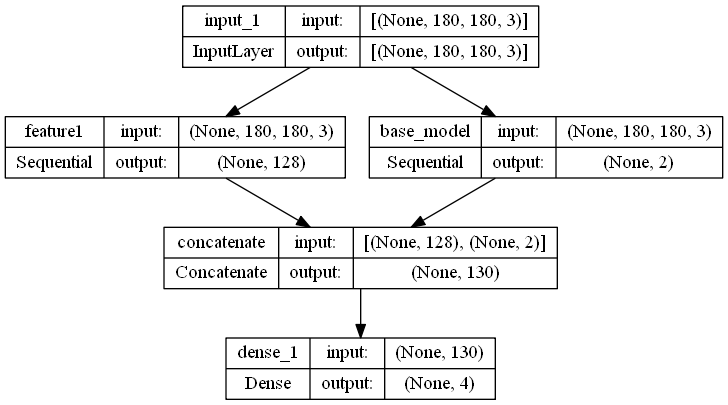

In [28]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='final_model_arch.png', show_shapes=True, show_layer_names=True)

# Train the model

In [29]:
callback1 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1, verbose=1)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=1, verbose=1)
callback3 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
callback4 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)

In [30]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    shuffle=True,
    callbacks=[callback1, callback2, callback3, callback4]
    # callbacks=[callback1,]
)

Epoch 1/10
649/649 [==============================] - 59s 30ms/step - loss: 0.9989 - accuracy: 0.7095 - val_loss: 0.6599 - val_accuracy: 0.8116
Epoch 2/10
649/649 [==============================] - 11s 17ms/step - loss: 0.5378 - accuracy: 0.8503 - val_loss: 0.3960 - val_accuracy: 0.9045
Epoch 3/10
649/649 [==============================] - 11s 17ms/step - loss: 0.3357 - accuracy: 0.9197 - val_loss: 0.2885 - val_accuracy: 0.9280
Epoch 4/10
649/649 [==============================] - 11s 17ms/step - loss: 0.2080 - accuracy: 0.9541 - val_loss: 0.1686 - val_accuracy: 0.9653
Epoch 5/10
649/649 [==============================] - 11s 17ms/step - loss: 0.1325 - accuracy: 0.9740 - val_loss: 0.1472 - val_accuracy: 0.9601
Epoch 6/10
649/649 [==============================] - 12s 18ms/step - loss: 0.0950 - accuracy: 0.9812 - val_loss: 0.1077 - val_accuracy: 0.9705
Epoch 7/10
649/649 [==============================] - 11s 17ms/step - loss: 0.0770 - accuracy: 0.9841 - val_loss: 0.0835 - val_accuracy:

In [31]:
model.save('../saved_model/final_model.h5')

# Visualize accuracy and loss

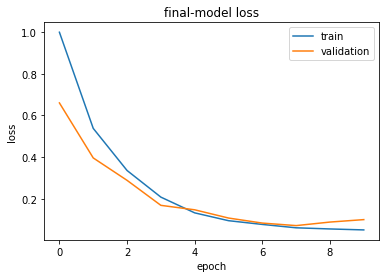

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('final-model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('final_model-loss.png')
plt.show()

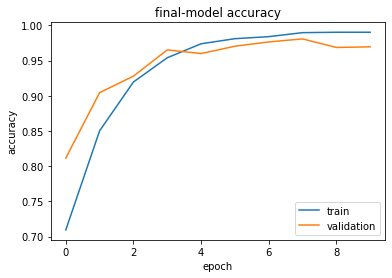

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('final-model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('final_model-accuracy.png')
plt.show()

# Evaluate the model on test data

In [32]:
data_dir_test = pathlib.Path('../dataset_stages/test')
data_dir_test

WindowsPath('../dataset_stages/test')

In [33]:
image_count = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count)

1279


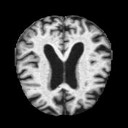

In [34]:
mild = list(data_dir.glob('Mild_Demented/*'))
PIL.Image.open(str(mild[0]))

## Create test dataset

In [35]:
batch_size = 16
img_height = 180
img_width = 180

In [88]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=0,
  labels='inferred',
  label_mode='int',
  image_size=(img_height, img_width),
  batch_size=1)

test_ds

Found 1279 files belonging to 4 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Evaluate on test set

In [37]:
model.evaluate(test_ds)

80/80 [==============================] - 2s 17ms/step - loss: 0.1482 - accuracy: 0.9429


[0.1482134908437729, 0.9429241418838501]

In [89]:
predictions = model.predict(test_ds)
predictions = np.array([np.argmax(x) for x in predictions])

1279/1279 [==============================] - 5s 4ms/step


In [87]:
predictions

array([3, 2, 3, ..., 0, 0, 0], dtype=int64)

In [107]:
predictions = []
labels = []
for x, y in test_ds:
    predictions.append(np.argmax(model.predict(x, verbose=0)))
    labels.append(y.numpy()[0])

## Confusion Matrix

In [108]:
cm = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
cm

array([[178,   0,   0,   1],
       [  1,  11,   0,   0],
       [ 11,   0, 582,  47],
       [ 11,   0,   2, 435]])

<AxesSubplot:>

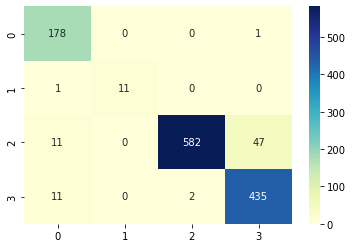

In [112]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")

## Classification Report

In [110]:
from sklearn.metrics import classification_report as cls_report

print(cls_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       179
           1       1.00      0.92      0.96        12
           2       1.00      0.91      0.95       640
           3       0.90      0.97      0.93       448

    accuracy                           0.94      1279
   macro avg       0.95      0.95      0.94      1279
weighted avg       0.95      0.94      0.94      1279

